<a href="https://colab.research.google.com/github/AlejandroZam/MeDIno/blob/main/MeDino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install python3.6
!pip3 install torch==1.7.1 torchvision==0.8.2 nvcc==11.0
!pip install timm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.6 is already the newest version (3.6.9-1~18.04ubuntu1.7).
python3.6 set to manually installed.
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
     |████████████████████████████████| 776.8 MB 15 kB/s 
     |████████████████████████████████| 12.8 MB 80.7 MB/s 
ERROR: Could not find a version that satisfies the requirement nvcc==11.0 (from versions: none)
ERROR: No matching distribution found for nvcc==11.0
     |████████████████████████████████| 431 kB 14.7 MB/s 


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import sys
import os
import pandas as pd
import timm
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from PIL import Image
import random

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not os.path.exists('EPILLID'):
  !unzip /content/drive/MyDrive/dataset/ePillID_data.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-516_0_0.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-516_0_1.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-517_0_0.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-517_0_1.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-518_0_0.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-518_0_1.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-519_0_0.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-519_0_1.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-520_0_0.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-520_0_1.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-525_0_0.jpg  
  inflating: /content/ePillID_data/segmented_nih_pills_224/63739-525_0_1.jpg  
 

In [ ]:
epillid = '/content/ePillID_data'

In [ ]:
def kfold_split(root,ksplitfile,k):
    fileprefix = 'folds/pilltypeid_nih_sidelbls0.01_metric_5folds/base/pilltypeid_nih_sidelbls0.01_metric_5folds_'
    val_path = root + fileprefix + str(k) + '.csv'


    df = pd.read_csv(val_path)
    classes = df['label_code_id'].unique()
    classes.sort()
    print(classes)
    print(len(classes))
    # print(df)
    # print(df['label_code_id'].unique())
    #
    # print('here')

In [ ]:
jitter = T.ColorJitter(brightness=.5, hue=.3,saturation=.2,contrast =.2)

In [ ]:
rotater = T.RandomRotation(degrees=(0, 180))
hflipper = T.RandomHorizontalFlip(p=0.5)
vflipper = T.RandomVerticalFlip(p=0.5)

In [ ]:
def add_augmentations(root,img_list,num):
  images_to_aug = []
  final_img_list = []
  # 
  aug_base = ['rotate','hflip','vflip']

  for i in range(num):
    index = random.randint(0,len(img_list)-1)
    #images_to_aug.append(img_list[index])
    img_path = root + '/' + img_list[index]
    image_to_aug = Image.open(img_path)
    image_to_aug = image_to_aug.convert('RGB')

    image_to_aug = jitter(image_to_aug)

    image_to_aug = rotater(image_to_aug)
    image_to_aug = hflipper(image_to_aug)
    image_to_aug = vflipper(image_to_aug)

    new_path = img_list[index].replace('.jpg','_aug_' + str(i) + '_.jpg' )
 
    img_list.append(new_path)
    #plt.imshow(image_to_aug)
    image_to_aug.save(root+'/'+new_path)

  return img_list

In [ ]:
def dc_train_dr_val_split_front(root):
  fileprefix = 'all_labels.csv'
  labels = root + '/' + fileprefix
  df = pd.read_csv(labels)
  df = df[df['is_front'] == True]
  df = df[df['is_new'] == False]
  classes = df['label'].unique()
  classes.sort()
  # print('classes = ',len(classes))
  datasetstruct = {}
  for c in classes:
      tempdf = df.copy()
      # print('total len of images',len(tempdf))
      images_df = tempdf.loc[tempdf['label'] == c]
      # print('class ', c)
      # print('number of imgs in class ',len(images_df))
      # images_df_f = images_df.loc[images_df['is_front'] == True]
      # print('front images in class ',len(images_df_f))
      # datasetstruct[c] = images_df_f.image_path.values.tolist()
      c_imgs = images_df.image_path.values.tolist()

      if len(c_imgs) <= 2:
        pass
      elif len(c_imgs) != 10:
        c_imgs = add_augmentations(root,c_imgs,10 - len(c_imgs))
        datasetstruct[c] = c_imgs
      else:
        datasetstruct[c] = c_imgs

  return datasetstruct

In [ ]:
foldermap = dc_train_dr_val_split_front(epillid)


In [ ]:
def dc_dr_split(root):
    fileprefix = 'all_labels.csv'
    labels = root + '/' + fileprefix
    df = pd.read_csv(labels)
    classes = df['label_code_id'].unique()
    classes.sort()
    # print('classes = ',len(classes))
    datasetstruct = {}
    for c in classes:
        tempdf = df.copy()
        # print('total len of images',len(tempdf))
        images_df = tempdf.loc[tempdf['label_code_id'] == c]
        # print('class ', c)
        # print('number of imgs in class ',len(images_df))
        # images_df_f = images_df.loc[images_df['is_front'] == True]
        # print('front images in class ',len(images_df_f))
        # datasetstruct[c] = images_df_f.image_path.values.tolist()
        datasetstruct[c] = images_df.image_path.values.tolist()

    return datasetstruct

In [ ]:
def create_dataset_folder(src_dir,dest_dir,img_dict):

    print(src_dir)
    print(dest_dir)
    for k,v in img_dict.items():
      print('class: ',k)
      classdir = dest_dir+'/_'+str(k)+'_'
      try:
        os.mkdir(classdir)
      
      except:
        print('label ',k,' is already in directory ',dest_dir)

      for img in v:
        imgfile = img.split('/')[-1]
        print(img,' copied')
        shutil.copy(src_dir+'/'+img,classdir + '/' + imgfile)


In [ ]:
def create_train_val_folder(src_dir,dest_dir,split=0.8):

    try:
      os.mkdir(dest_dir)
    except:
      pass

    train_p = dest_dir + '/'+'train'
    val_p = dest_dir + '/'+'val'

    try:
      os.mkdir(train_p)
    except:
      pass

    try:
      os.mkdir(val_p)
    except:
      pass

    for d in os.listdir(src_dir):
      dir = src_dir + '/' + d
      files = os.listdir(dir)
      print(d)
      print(len(files))
      print(files)
      ratio = int(len(files) * split)
      print(ratio)
      if ratio > 3:
        random.shuffle(files)
        tr_files = files[:ratio]
        val_files = files[ratio:]
        try:
          os.mkdir(train_p + '/'+ d)
        except:
          pass
        try:
          os.mkdir(val_p + '/'+ d)
        except:
          pass
        for t in tr_files:
          shutil.copy(dir+'/'+t,train_p + '/'+ d + '/' + t)

        for v in val_files:
          shutil.copy(dir+'/'+v,val_p + '/'+ d + '/' + v)

      

      



In [ ]:
!git clone https://github.com/AlejandroZam/MeDIno.git

Cloning into 'MeDIno'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 5), reused 25 (delta 5), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [ ]:
labeldict = dc_dr_split(epillid)

In [ ]:
!mkdir /content/e_pill_id_dataset

In [ ]:
dataset = '/content/e_pill_id_dataset'

In [ ]:
create_dataset_folder(epillid,dataset,labeldict)

In [ ]:
create_dataset_folder(epillid,dataset,foldermap)

Streaming output truncated to the last 5000 lines.
fcn_mix_weight/dc_224/3510_aug_1_.jpg  copied
fcn_mix_weight/dr_224/00093-7214-98_PART_1_OF_1_CHAL10_SF_C929E4EF_aug_2_.jpg  copied
fcn_mix_weight/dr_224/00093-7214-98_PART_1_OF_1_CHAL10_SF_C929E4EF_aug_2__aug_3_.jpg  copied
fcn_mix_weight/dc_224/3510_aug_4_.jpg  copied
fcn_mix_weight/dc_224/3510_aug_5_.jpg  copied
fcn_mix_weight/dr_224/00093-7214-98_PART_1_OF_1_CHAL10_SF_C929E4EF_aug_0__aug_6_.jpg  copied
class:  00093-7219-06_72293959
fcn_mix_weight/dc_224/3128.jpg  copied
fcn_mix_weight/dc_224/4448.jpg  copied
fcn_mix_weight/dr_224/00093-7219-06_PART_1_OF_1_CHAL10_SF_72293959.jpg  copied
fcn_mix_weight/dc_224/4448_aug_0_.jpg  copied
fcn_mix_weight/dc_224/4448_aug_0__aug_1_.jpg  copied
fcn_mix_weight/dc_224/4448_aug_2_.jpg  copied
fcn_mix_weight/dc_224/4448_aug_2__aug_3_.jpg  copied
fcn_mix_weight/dc_224/4448_aug_0__aug_1__aug_4_.jpg  copied
fcn_mix_weight/dc_224/4448_aug_5_.jpg  copied
fcn_mix_weight/dc_224/4448_aug_6_.jpg  copied
c

In [ ]:
create_train_val_folder('/content/e_pill_id_dataset','/content/e_pill_id_imagenet',0.8)

_00054-0017-25_F7217BFB_
10
['4928.jpg', '174_aug_2_.jpg', '00054-0017-25_PART_1_OF_1_CHAL10_SF_F7217BFB_aug_1_.jpg', '2047.jpg', '00054-0017-25_PART_1_OF_1_CHAL10_SF_F7217BFB_aug_1__aug_4__aug_5_.jpg', '00054-0017-25_PART_1_OF_1_CHAL10_SF_F7217BFB_aug_1__aug_4_.jpg', '4928_aug_3_.jpg', '00054-0017-25_PART_1_OF_1_CHAL10_SF_F7217BFB.jpg', '174.jpg', '174_aug_0_.jpg']
8
_00093-3171-01_10268814_
10
['00093-3171-01_PART_1_OF_1_CHAL10_SF_10268814_aug_1__aug_3_.jpg', '3451_aug_0_.jpg', '00093-3171-01_PART_1_OF_1_CHAL10_SF_10268814_aug_1_.jpg', '1126_aug_2__aug_4_.jpg', '1126.jpg', '3440.jpg', '1126_aug_2_.jpg', '3451.jpg', '3297.jpg', '00093-3171-01_PART_1_OF_1_CHAL10_SF_10268814.jpg']
8
_68462-0163-01_DC216E7B_
10
['2447.jpg', '4048_aug_1__aug_3_.jpg', '4048_aug_0__aug_6_.jpg', '4048_aug_1_.jpg', '2447_aug_2_.jpg', '2447_aug_2__aug_4_.jpg', '4048_aug_1__aug_5_.jpg', '4048.jpg', '4048_aug_0_.jpg', '68462-0163-01_PART_1_OF_1_CHAL10_SF_DC216E7B.jpg']
8
_00093-7670-01_8327C19E_
10
['1286.jpg', 

In [ ]:
len(os.listdir('/content/e_pill_id_imagenet/train'))

683

In [ ]:
len(os.listdir('/content/e_pill_id_imagenet/val'))

683

In [ ]:
%cd MeDIno/

/content/MeDIno


In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 main_dino.py --out_dim=1024 --epochs 100 --batch_size_per_gpu 10 --arch vit_small --patch_size 8 --data_path /content/e_pill_id_dataset --output_dir /content/output

In [ ]:
imagetestref = Image.open('/content/ePillID_data/fcn_mix_weight/dr_224/00009-0055-01_PART_1_OF_1_CHAL10_SF_CA1DE53F.jpg')
imagetestref = imagetestref.convert('RGB')
imagetestref = imagetestref.resize((224,224))
imagetestref.save('/content/testref.png')

In [ ]:
imagetestcon = Image.open('/content/ePillID_data/fcn_mix_weight/dc_224/0.jpg')
imagetestcon = imagetestcon.convert('RGB')
imagetestcon = imagetestcon.resize((224,224))
imagetestcon.save('/content/testcon.png')

In [ ]:
def extract_log_pretrain_metrics(log_path):
  f = open(log_path)
  data = f.readlines()
  f.close()
  tr_loss = []

  for d in data:
    js = json.loads(d)

    tr_loss.append(js['train_loss'])

  return tr_loss

In [ ]:
loss_c = extract_log_pretrain_metrics('/content/drive/MyDrive/grad/medimagespring22/medino_vit_small_output/log.txt')

In [ ]:
loss_ce = extract_log_pretrain_metrics('/content/drive/MyDrive/grad/medimagespring22/medino_vit_small_epillid_output/log.txt')

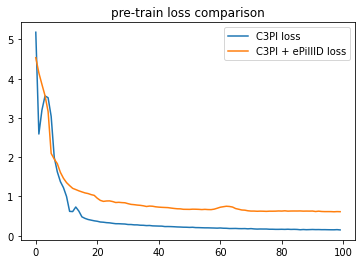

In [ ]:
num_epochs = len(loss_c)
epochs = list(range(0,num_epochs))
plt.title('pre-train loss comparison')
plt.plot(epochs, loss_c, label = "C3PI loss")
plt.plot(epochs, loss_ce, label = "C3PI + ePillID loss")
plt.legend()
plt.show()

imagnet pretrain

In [ ]:
!python visualize_attention.py --threshold .7 --image_path /content/testcon.png

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
/content/testcon_attn-head0.png saved.
/content/testcon_attn-head1.png saved.
/content/testcon_attn-head2.png saved.
/content/testcon_attn-head3.png saved.
/content/testcon_attn-head4.png saved.
/content/testcon_attn-head5.png saved.
./mask_th0.7_head0.png saved.
./mask_th0.7_head1.png saved.
./mask_th0.7_head2.png saved.
./mask_th0.7_head3.png saved.
./mask_th0.7_head4.png saved.
./mask_th0.7_head5.png saved.


In [ ]:
!python visualize_attention.py --threshold .7 --image_path /content/testref.png

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
/content/testref_attn-head0.png saved.
/content/testref_attn-head1.png saved.
/content/testref_attn-head2.png saved.
/content/testref_attn-head3.png saved.
/content/testref_attn-head4.png saved.
/content/testref_attn-head5.png saved.
./mask_th0.7_head0.png saved.
./mask_th0.7_head1.png saved.
./mask_th0.7_head2.png saved.
./mask_th0.7_head3.png saved.
./mask_th0.7_head4.png saved.
./mask_th0.7_head5.png saved.


c3pi and epillid pretrain

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_epillid_output/checkpoint.pth --image_path /content/testcon.png

Take key teacher in provided checkpoint dict
Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_epillid_output/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
/content/testcon_attn-head0.png saved.
/content/testcon_attn-head1.png saved.
/content/testcon_attn-head2.png saved.
/content/testcon_attn-head3.png saved.
/content/testcon_attn-head4.png saved.
/content/testcon_attn-head5.png saved.
./mask_th0.7_head0.png saved.
./mask_th0.7_head1.png saved.
./mask_th0.7_head2.png saved.
./mask_th0.7_head3.png saved.
./mask_th0.7_head4.png saved.
./mask_th0.7_head5.png saved.


In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_epillid_output/checkpoint.pth --image_path /content/testref.png

Take key teacher in provided checkpoint dict
Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_epillid_output/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
/content/testref_attn-head0.png saved.
/content/testref_attn-head1.png saved.
/content/testref_attn-head2.png saved.
/content/testref_attn-head3.png saved.
/content/testref_attn-head4.png saved.
/content/testref_attn-head5.png saved.
./mask_th0.7_head0.png saved.
./mask_th0.7_head1.png saved.
./mask_th0.7_head2.png saved.
./mask_th0.7_head3.png saved.
./mask_th0.7_head4.png saved.
./mask_th0.7_head5.png saved.


c3pi pretrain only

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_output/checkpoint.pth --image_path /content/testcon.png

Take key teacher in provided checkpoint dict
Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_output/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
/content/testcon_attn-head0.png saved.
/content/testcon_attn-head1.png saved.
/content/testcon_attn-head2.png saved.
/content/testcon_attn-head3.png saved.
/content/testcon_attn-head4.png saved.
/content/testcon_attn-head5.png saved.
./mask_th0.7_head0.png saved.
./mask_th0.7_head1.png saved.
./mask_th0.7_head2.png saved.
./mask_th0.7_head3.png saved.
./mask_th0.7_head4.png saved.
./mask_th0.7_head5.png saved.


In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_output/checkpoint.pth --image_path /content/testref.png

Take key teacher in provided checkpoint dict
Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_output/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
/content/testref_attn-head0.png saved.
/content/testref_attn-head1.png saved.
/content/testref_attn-head2.png saved.
/content/testref_attn-head3.png saved.
/content/testref_attn-head4.png saved.
/content/testref_attn-head5.png saved.
./mask_th0.7_head0.png saved.
./mask_th0.7_head1.png saved.
./mask_th0.7_head2.png saved.
./mask_th0.7_head3.png saved.
./mask_th0.7_head4.png saved.
./mask_th0.7_head5.png saved.


linear classifier training 

imagnet linear training

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 eval_linear.py --batch_size_per_gpu 16 --arch vit_small --num_labels 683 --patch_size 8 --epochs 200 --n_last_blocks 1 --checkpoint_key teacher --data_path /content/e_pill_id_imagenet

/usr/local/lib/python3.7/dist-packages/torch/distributed/launch.py:186: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  FutureWarning,
| distributed init (rank 0): env://
git:
  sha: 8a9991d334441e121aad709b3a443dff395d4411, status: has uncommited changes, branch: main

arch: vit_small
avgpool_patchtokens: False
batch_size_per_gpu: 16
checkpoint_key: teacher
data_path: /content/e_pill_id_imagenet
dist_url: env://
epochs: 200
evaluate: False
gpu: 0
local_rank: 0
lr: 0.001
n_last_blocks: 1
num_labels: 683
num_workers: 10
output_dir: .
patch_size: 8
pretrained_weights: 
rank: 0
val_freq: 1
world_size: 1
Please use the `--pretrained_weights` argument to indicat

In [ ]:
shutil.copy('/content/MeDIno/checkpoint.pth.tar','/content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet')
shutil.copy('/content/MeDIno/log.txt','/content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet')


'/content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet/log.txt'

c3pi linear training

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 eval_linear.py --batch_size_per_gpu 16 --arch vit_small --num_labels 683 --patch_size 8 --epochs 200 --n_last_blocks 1 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_output/checkpoint.pth --checkpoint_key teacher --data_path /content/e_pill_id_imagenet

Streaming output truncated to the last 5000 lines.
Test:  [60/86]  eta: 0:00:02  loss: 5.972717 (5.965369)  acc1: 0.000000 (3.790984)  acc5: 12.500000 (11.168033)  time: 0.090506  data: 0.000171  max mem: 661
Test:  [80/86]  eta: 0:00:00  loss: 5.983692 (5.971271)  acc1: 0.000000 (3.703704)  acc5: 6.250000 (10.648148)  time: 0.090497  data: 0.000146  max mem: 661
Test:  [85/86]  eta: 0:00:00  loss: 6.029927 (5.979846)  acc1: 0.000000 (3.733529)  acc5: 6.250000 (10.541728)  time: 0.087700  data: 0.000143  max mem: 661
Test: Total time: 0:00:08 (0.096095 s / it)
* Acc@1 3.734 Acc@5 10.542 loss 5.980
Accuracy at epoch 38 of the network on the 1366 test images: 3.7%
Max accuracy so far: 3.73%
Epoch: [39]  [  0/342]  eta: 0:03:22  lr: 0.000057  loss: 5.719723 (5.719723)  time: 0.592601  data: 0.500496  max mem: 661
Epoch: [39]  [ 20/342]  eta: 0:00:36  lr: 0.000057  loss: 5.783587 (5.790656)  time: 0.090719  data: 0.000187  max mem: 661
Epoch: [39]  [ 40/342]  eta: 0:00:31  lr: 0.000057  lo

In [ ]:
shutil.copy('/content/MeDIno/checkpoint.pth.tar','/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi')
shutil.copy('/content/MeDIno/log.txt','/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi')


'/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi/log.txt'

c3pi + epillid linear training

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 eval_linear.py --batch_size_per_gpu 16 --arch vit_small --num_labels 683 --patch_size 8 --epochs 200 --n_last_blocks 3 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/medino_vit_small_epillid_output/checkpoint.pth --checkpoint_key teacher --data_path /content/e_pill_id_imagenet

Streaming output truncated to the last 5000 lines.
Test:  [60/86]  eta: 0:00:02  loss: 5.480344 (5.520061)  acc1: 6.250000 (7.581967)  acc5: 25.000000 (21.004098)  time: 0.090730  data: 0.000141  max mem: 741
Test:  [80/86]  eta: 0:00:00  loss: 5.579610 (5.530799)  acc1: 6.250000 (7.638889)  acc5: 18.750000 (20.447531)  time: 0.090754  data: 0.000112  max mem: 741
Test:  [85/86]  eta: 0:00:00  loss: 5.594733 (5.529064)  acc1: 6.250000 (7.393851)  acc5: 18.750000 (20.204978)  time: 0.087972  data: 0.000101  max mem: 741
Test: Total time: 0:00:08 (0.096479 s / it)
* Acc@1 7.394 Acc@5 20.205 loss 5.529
Accuracy at epoch 38 of the network on the 1366 test images: 7.4%
Max accuracy so far: 7.39%
Epoch: [39]  [  0/342]  eta: 0:03:27  lr: 0.000057  loss: 5.186201 (5.186201)  time: 0.605286  data: 0.513641  max mem: 741
Epoch: [39]  [ 20/342]  eta: 0:00:37  lr: 0.000057  loss: 5.017311 (5.062283)  time: 0.092032  data: 0.001338  max mem: 741
Epoch: [39]  [ 40/342]  eta: 0:00:31  lr: 0.000057  

In [ ]:
shutil.copy('/content/MeDIno/checkpoint.pth.tar','/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid')
shutil.copy('/content/MeDIno/log.txt','/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid')


'/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid/log.txt'

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet/checkpoint.pth.tar --image_path /content/testcon.png

Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet/checkpoint.pth.tar and loaded with msg: _IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'b

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet/checkpoint.pth.tar --image_path /content/testref.png

Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet/checkpoint.pth.tar and loaded with msg: _IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'b

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi/checkpoint.pth.tar --image_path /content/testcon.png

Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi/checkpoint.pth.tar and loaded with msg: _IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'block

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi/checkpoint.pth.tar --image_path /content/testref.png

Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi/checkpoint.pth.tar and loaded with msg: _IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'block

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid/checkpoint.pth.tar --image_path /content/testcon.png

Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid/checkpoint.pth.tar and loaded with msg: _IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight'

In [ ]:
!python visualize_attention.py --threshold .7 --pretrained_weights /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid/checkpoint.pth.tar --image_path /content/testref.png

Pretrained weights found at /content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid/checkpoint.pth.tar and loaded with msg: _IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight'

In [ ]:
def extract_log_metrics(log_path):
  f = open(log_path)
  data = f.readlines()
  f.close()
  tr_loss = []
  te_loss = []
  te_acc1 = []
  te_acc5 = []
  for d in data:
    js = json.loads(d)

    tr_loss.append(js['train_loss'])
    te_loss.append(js['test_loss'])
    te_acc1.append(js['test_acc1'])
    te_acc5.append(js['test_acc5'])

  return tr_loss,te_loss,te_acc1,te_acc5



In [ ]:
train_l,test_l,test_ac1,test_ac5 = extract_log_metrics('/content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet/log.txt')

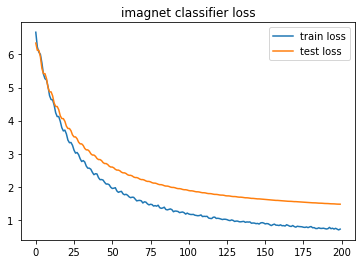

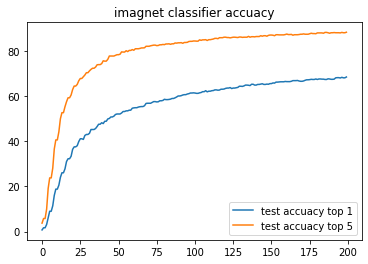

In [ ]:
train_l,test_l,test_ac1,test_ac5 = extract_log_metrics('/content/drive/MyDrive/grad/medimagespring22/linear_weights/imagenet/log.txt')
num_epochs = len(train_l)
epochs = list(range(0,num_epochs))
plt.title('imagnet classifier loss')
plt.plot(epochs, train_l, label = "train loss")
plt.plot(epochs, test_l, label = "test loss")
plt.legend()
plt.show()
plt.title('imagnet classifier accuacy')
plt.plot(epochs, test_ac1, label = "test accuacy top 1")
plt.plot(epochs, test_ac5, label = "test accuacy top 5")
plt.legend()
plt.show()

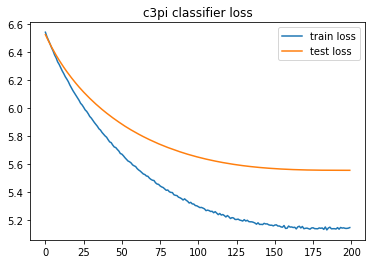

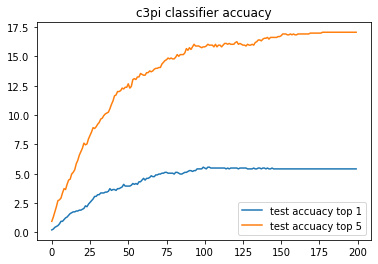

In [ ]:
train_l_c,test_l_c,test_ac1_c,test_ac5_c = extract_log_metrics('/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi/log.txt')
num_epochs_c = len(train_l_c)
epochs_c = list(range(0,num_epochs_c))
plt.title('c3pi classifier loss')
plt.plot(epochs_c, train_l_c, label = "train loss")
plt.plot(epochs_c, test_l_c, label = "test loss")
plt.legend()
plt.show()
plt.title('c3pi classifier accuacy')
plt.plot(epochs_c, test_ac1_c, label = "test accuacy top 1")
plt.plot(epochs_c, test_ac5_c, label = "test accuacy top 5")
plt.legend()
plt.show()

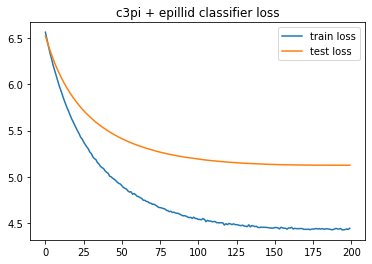

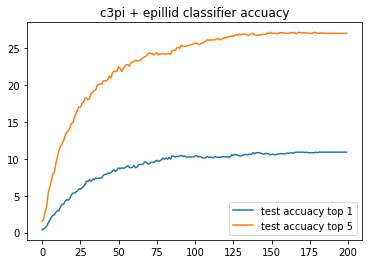

In [ ]:
train_l_ce,test_l_ce,test_ac1_ce,test_ac5_ce = extract_log_metrics('/content/drive/MyDrive/grad/medimagespring22/linear_weights/c3pi_epillid/log.txt')
num_epochs_ce = len(train_l_ce)
epochs_ce = list(range(0,num_epochs_ce))
plt.title('c3pi + epillid classifier loss')
plt.plot(epochs_ce, train_l_ce, label = "train loss")
plt.plot(epochs_ce, test_l_ce, label = "test loss")
plt.legend()
plt.show()
plt.title('c3pi + epillid classifier accuacy')
plt.plot(epochs_ce, test_ac1_ce, label = "test accuacy top 1")
plt.plot(epochs_ce, test_ac5_ce, label = "test accuacy top 5")
plt.legend()
plt.show()

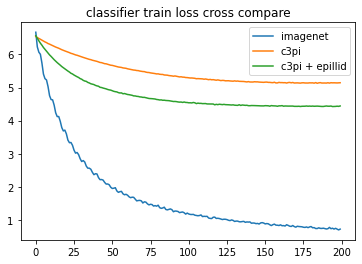

In [ ]:
plt.title('classifier train loss cross compare')
plt.plot(epochs, train_l, label = "imagenet")
plt.plot(epochs, train_l_c, label = "c3pi")
plt.plot(epochs, train_l_ce, label = "c3pi + epillid")
plt.legend()
plt.show()

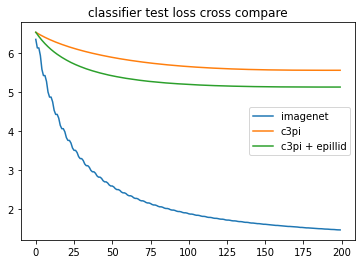

In [ ]:
plt.title('classifier test loss cross compare')
plt.plot(epochs, test_l, label = "imagenet")
plt.plot(epochs, test_l_c, label = "c3pi")
plt.plot(epochs, test_l_ce, label = "c3pi + epillid")
plt.legend()
plt.show()

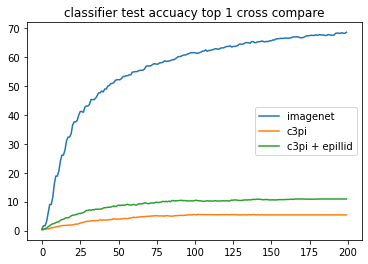

In [ ]:
plt.title('classifier test accuacy top 1 cross compare')
plt.plot(epochs, test_ac1, label = "imagenet")
plt.plot(epochs, test_ac1_c, label = "c3pi")
plt.plot(epochs, test_ac1_ce, label = "c3pi + epillid")
plt.legend()
plt.show()

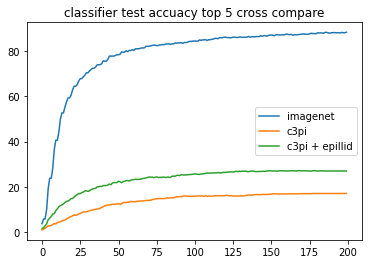

In [ ]:
plt.title('classifier test accuacy top 5 cross compare')
plt.plot(epochs, test_ac5, label = "imagenet")
plt.plot(epochs, test_ac5_c, label = "c3pi")
plt.plot(epochs, test_ac5_ce, label = "c3pi + epillid")
plt.legend()
plt.show()